In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from pathlib import Path

In [4]:
def load(
    stem: str,
    base_path=Path("~/.kaggle/data/hourly-energy-consumption"),
    as_series=True,
):
    df = pd.read_csv(base_path / f"{stem}.csv")
    df = df.set_index("Datetime")
    df.index = pd.to_datetime(df.index)
    if len(df.columns == 1) and as_series:
        return df[df.columns[0]]
    else:
        return df

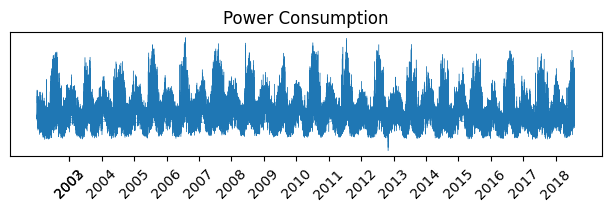

In [5]:
s = load("PJME_hourly")
figure = plt.figure(figsize=(6, 2), layout="constrained")
plt.plot(s.index, s.values, lw=0.3)
year_starts = pd.Series(s.index.year, index=s.index).drop_duplicates(keep="first")
plt.xticks(year_starts.index, year_starts, rotation=45)
plt.yticks([])
plt.title("Power Consumption")
plt.show()

### Trend?

In [6]:
s.mean(), s.std()

(np.float64(32080.222830648156), np.float64(6464.012166412735))

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

model = LinearRegression()
y = s.values
X = np.arange(len(y)).reshape(-1, 1)
model.fit(X, y)
model.intercept_, model.coef_.item()
rmse = root_mean_squared_error(y, model.predict(X))
rmse

6453.956563307532

In [8]:
improvement = (s.std() - rmse) / s.std()
print(f"Linear trend decreases error by {100*improvement:.2f}% over the null model.")

Linear trend decreases error by 0.16% over the null model.


### Periodicity

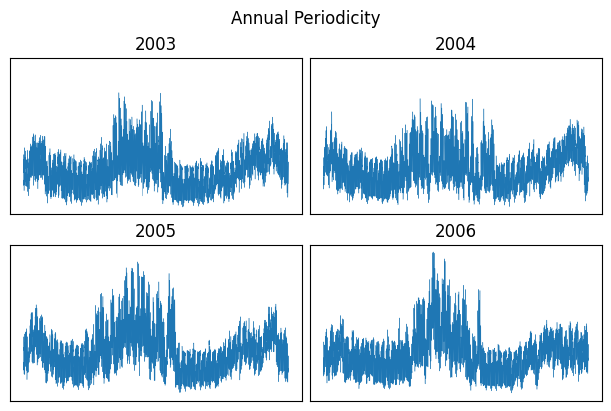

In [9]:
year = s.index.year

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(6, 4), layout="constrained", sharey=True
)
fig.suptitle("Annual Periodicity")
for y, ax in zip([2003, 2004, 2005, 2006], axes.ravel()):
    ax.plot(s[year == y].values, lw=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(y))

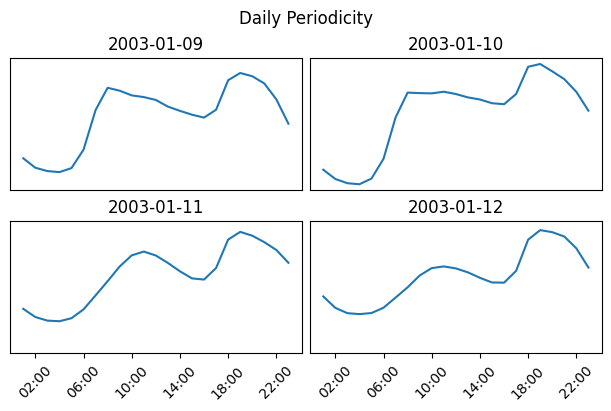

In [10]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(6, 4), layout="constrained", sharey=True
)
fig.suptitle("Daily Periodicity")
for d, ax in zip(np.arange(4) + 9, axes.ravel()):
    t = s[(year == 2003) & (s.index.dayofyear == d)]
    ax.plot(t.index.hour.values[:-1], t.values[:-1])
    if d > 10:
        hours = t.index.hour[1::4]
        ax.set_xticks(
            hours,
            [f"{h:02d}:00" for h in hours],
            rotation=45,
        )
    else:
        ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(t.index[0].date())

### Seasonality

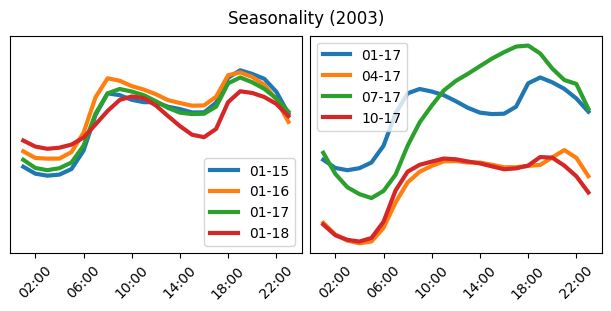

In [11]:
fig, (left, right) = plt.subplots(
    nrows=1, ncols=2, figsize=(6, 3), layout="constrained", sharey=True
)
fig.suptitle("Seasonality (2003)")

for d in np.arange(4) + 15:
    t = s[(year == 2003) & (s.index.dayofyear == d)]
    left.plot(
        t.index.hour.values[:-1],
        t.values[:-1],
        lw=3,
        label=f"{t.index[0].month:02d}-{t.index[0].day:02d}",
    )
left.legend(loc="lower right")
left.set_yticks([])
hours = t.index.hour[1::4]
left.set_xticks(
    hours,
    [f"{h:02d}:00" for h in hours],
    rotation=45,
)


for m, d in zip([1, 4, 7, 10], [17, 17, 17, 17]):
    t = s[(s.index.year == 2003) & (s.index.month == m) & (s.index.day == d)]
    right.plot(
        t.index.hour[:-1],
        t[:-1],
        lw=3,
        label=f"{t.index[0].month:02d}-{t.index[0].day:02d}",
    )
right.set_xticks(
    hours,
    [f"{h:02d}:00" for h in hours],
    rotation=45,
)
right.legend(loc="upper left")
plt.show()

In [12]:
def time_features(s):
    i = s.index
    return pd.DataFrame(
        {
            "hour": i.hour,
            "dayofweek": i.dayofweek,
            "quarter": i.quarter,
            "month": i.month,
            "dayofyear": i.dayofyear,
            "dayofmonth": i.day,
            "weekofyear": i.isocalendar().week,
        }
    )

In [13]:
X = time_features(s)

In [100]:
one_hot_encoder = OneHotEncoder()
XX = one_hot_encoder.fit_transform(X)
model = LinearRegression()
model.fit(XX, s)
u = pd.Series(model.predict(XX), index=s.index)

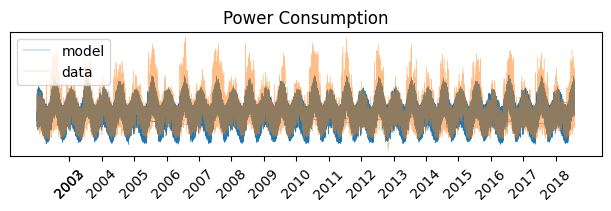

In [101]:
figure = plt.figure(figsize=(6, 2), layout="constrained")
plt.plot(u.index, u.values, lw=0.3, label="model")
plt.plot(s.index, s.values, lw=0.3, alpha=0.5, label="data")
year_starts = pd.Series(s.index.year, index=s.index).drop_duplicates(keep="first")
plt.xticks(year_starts.index, year_starts, rotation=45)
plt.yticks([])
plt.title("Power Consumption")
plt.legend()
plt.show()

In [102]:
rmse = root_mean_squared_error(s, u)
rmse

3656.0664540868906

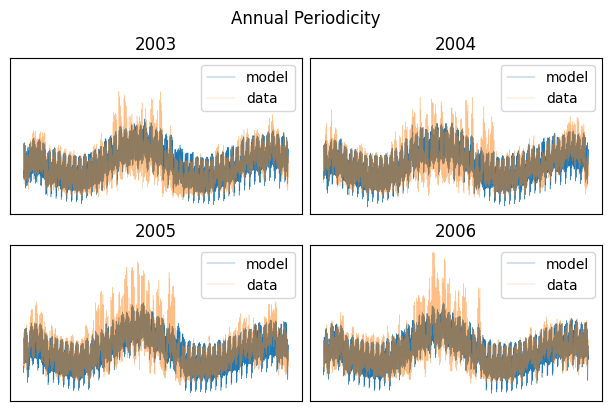

In [103]:
year = s.index.year

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(6, 4), layout="constrained", sharey=True
)
fig.suptitle("Annual Periodicity")
for y, ax in zip([2003, 2004, 2005, 2006], axes.ravel()):
    ax.plot(u[year == y].values, lw=0.3, label="model")
    ax.plot(s[year == y].values, lw=0.3, alpha=0.5, label="data")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(y))
    ax.legend()

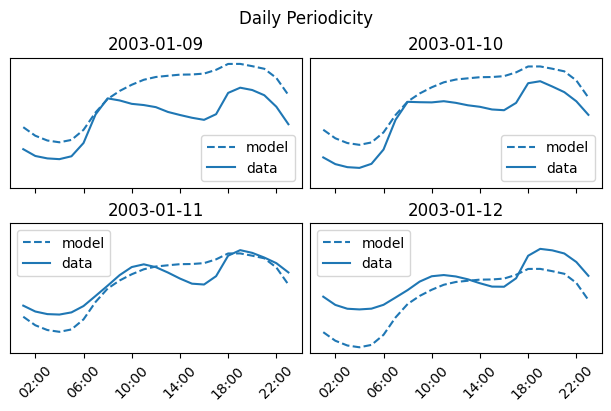

In [ ]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(6, 4), layout="constrained", sharex=True, sharey=True
)
fig.suptitle("Daily Periodicity")
for d, ax in zip(np.arange(4) + 9, axes.ravel()):
    indices = (year == 2003) & (s.index.dayofyear == d)
    t = s[indices]
    ax.plot(
        u[indices].index.hour.values[:-1], u[indices].values[:-1], "C0--", label="model"
    )
    ax.plot(
        s[indices].index.hour.values[:-1], s[indices].values[:-1], "C0", label="data"
    )
    if d > 10:
        hours = s[indices].index.hour[1::4]
        ax.set_xticks(
            hours,
            [f"{h:02d}:00" for h in hours],
            rotation=45,
        )
    else:
        ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(t.index[0].date())
    ax.legend()

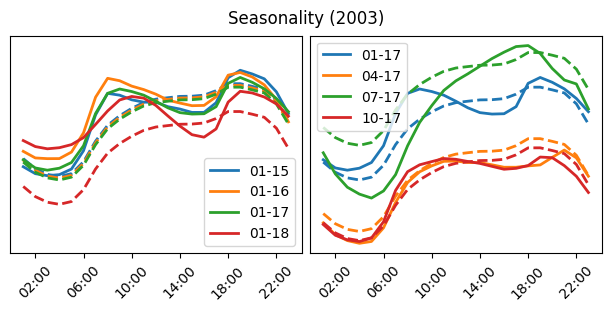

In [110]:
fig, (left, right) = plt.subplots(
    nrows=1, ncols=2, figsize=(6, 3), layout="constrained", sharey=True
)
fig.suptitle("Seasonality (2003)")

for i in np.arange(4):
    d = i + 15
    t = s[(year == 2003) & (s.index.dayofyear == d)]
    v = u[(year == 2003) & (u.index.dayofyear == d)]
    left.plot(
        t.index.hour.values[:-1],
        t.values[:-1],
        f"C{i}",
        lw=2,
        label=f"{t.index[0].month:02d}-{t.index[0].day:02d}",
    )
    left.plot(
        v.index.hour.values[:-1],
        v.values[:-1],
        f"C{i}--",
        lw=2,
    )
left.legend(loc="lower right")
left.set_yticks([])
hours = t.index.hour[1::4]
left.set_xticks(
    hours,
    [f"{h:02d}:00" for h in hours],
    rotation=45,
)


for i, (m, d) in enumerate(zip([1, 4, 7, 10], [17, 17, 17, 17])):
    t = s[(s.index.year == 2003) & (s.index.month == m) & (s.index.day == d)]
    v = u[(u.index.year == 2003) & (u.index.month == m) & (u.index.day == d)]
    right.plot(
        t.index.hour[:-1],
        t[:-1],
        f"C{i}",
        lw=2,
        label=f"{t.index[0].month:02d}-{t.index[0].day:02d}",
    )
    right.plot(
        v.index.hour[:-1],
        v[:-1],
        f"C{i}--",
        lw=2,
    )

right.set_xticks(
    hours,
    [f"{h:02d}:00" for h in hours],
    rotation=45,
)
right.legend(loc="upper left")
plt.show()

In [111]:
model = xgb.XGBRegressor(n_estimators=2000)
model.fit(XX, s)
u = pd.Series(model.predict(XX), index=s.index)
rmse = root_mean_squared_error(s, u)
rmse

2071.4981554275137

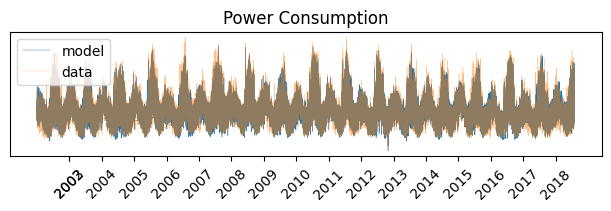

In [112]:
figure = plt.figure(figsize=(6, 2), layout="constrained")
plt.plot(u.index, u.values, lw=0.3, label="model")
plt.plot(s.index, s.values, lw=0.3, alpha=0.5, label="data")
year_starts = pd.Series(s.index.year, index=s.index).drop_duplicates(keep="first")
plt.xticks(year_starts.index, year_starts, rotation=45)
plt.yticks([])
plt.title("Power Consumption")
plt.legend()
plt.show()

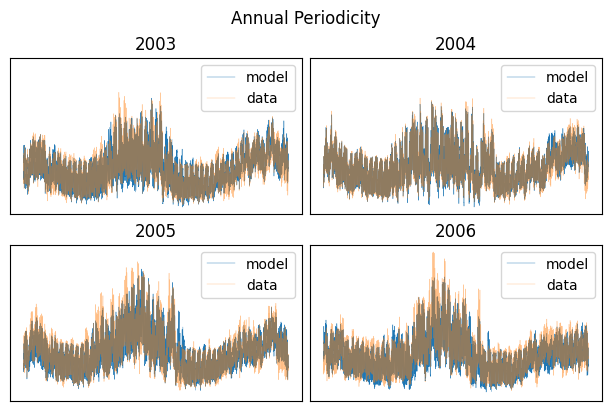

In [113]:
year = s.index.year

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(6, 4), layout="constrained", sharey=True
)
fig.suptitle("Annual Periodicity")
for y, ax in zip([2003, 2004, 2005, 2006], axes.ravel()):
    ax.plot(u[year == y].values, lw=0.3, label="model")
    ax.plot(s[year == y].values, lw=0.3, alpha=0.5, label="data")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(y))
    ax.legend()

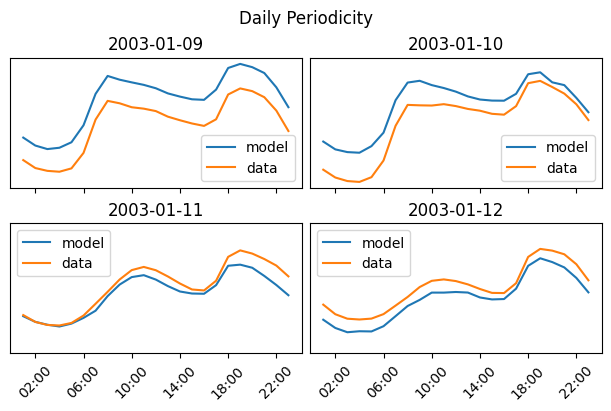

In [114]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(6, 4), layout="constrained", sharex=True, sharey=True
)
fig.suptitle("Daily Periodicity")
for d, ax in zip(np.arange(4) + 9, axes.ravel()):
    indices = (year == 2003) & (s.index.dayofyear == d)
    t = s[indices]
    ax.plot(u[indices].index.hour.values[:-1], u[indices].values[:-1], label="model")
    ax.plot(s[indices].index.hour.values[:-1], s[indices].values[:-1], label="data")
    if d > 10:
        hours = s[indices].index.hour[1::4]
        ax.set_xticks(
            hours,
            [f"{h:02d}:00" for h in hours],
            rotation=45,
        )
    else:
        ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(t.index[0].date())
    ax.legend()

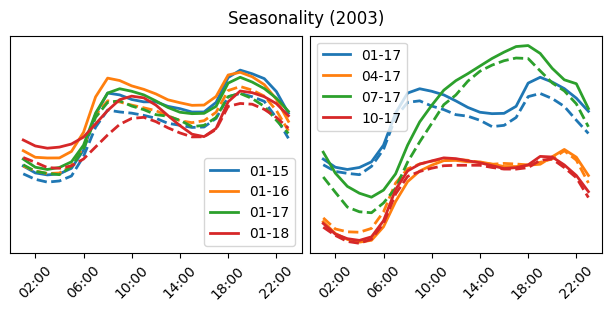

In [115]:
fig, (left, right) = plt.subplots(
    nrows=1, ncols=2, figsize=(6, 3), layout="constrained", sharey=True
)
fig.suptitle("Seasonality (2003)")

for i in np.arange(4):
    d = i + 15
    t = s[(year == 2003) & (s.index.dayofyear == d)]
    v = u[(year == 2003) & (u.index.dayofyear == d)]
    left.plot(
        t.index.hour.values[:-1],
        t.values[:-1],
        f"C{i}",
        lw=2,
        label=f"{t.index[0].month:02d}-{t.index[0].day:02d}",
    )
    left.plot(
        v.index.hour.values[:-1],
        v.values[:-1],
        f"C{i}--",
        lw=2,
    )
left.legend(loc="lower right")
left.set_yticks([])
hours = t.index.hour[1::4]
left.set_xticks(
    hours,
    [f"{h:02d}:00" for h in hours],
    rotation=45,
)


for i, (m, d) in enumerate(zip([1, 4, 7, 10], [17, 17, 17, 17])):
    t = s[(s.index.year == 2003) & (s.index.month == m) & (s.index.day == d)]
    v = u[(u.index.year == 2003) & (u.index.month == m) & (u.index.day == d)]
    right.plot(
        t.index.hour[:-1],
        t[:-1],
        f"C{i}",
        lw=2,
        label=f"{t.index[0].month:02d}-{t.index[0].day:02d}",
    )
    right.plot(
        v.index.hour[:-1],
        v[:-1],
        f"C{i}--",
        lw=2,
    )

right.set_xticks(
    hours,
    [f"{h:02d}:00" for h in hours],
    rotation=45,
)
right.legend(loc="upper left")
plt.show()

In [179]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv",
    parse_dates=["Month"],
    index_col="Month",
)
df.index.name = "Date"
df["logPassengers"] = np.log(df["Passengers"])
df

,Passengers,logPassengers
Date,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791
...,...,...
1960-08-01,606,6.406880
1960-09-01,508,6.230481
1960-10-01,461,6.133398


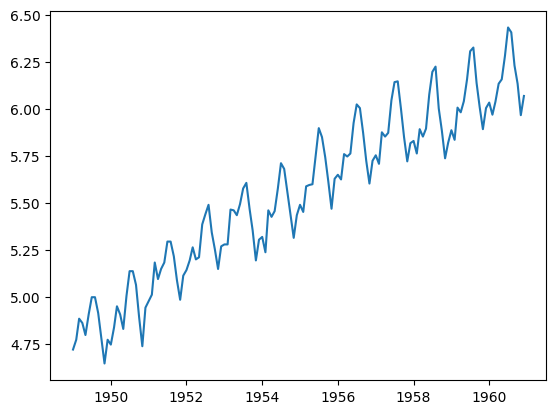

In [246]:
plt.plot(df["logPassengers"])
plt.show()

In [ ]:
df["t"] = (df.index.year - 1949) * 12 + df.index.month - 1
model = LinearRegression()
model.fit(df[["t"]], df["logPassengers"])
df["logTrend"] = pd.Series(model.predict(df[["t"]]), index=df.index)

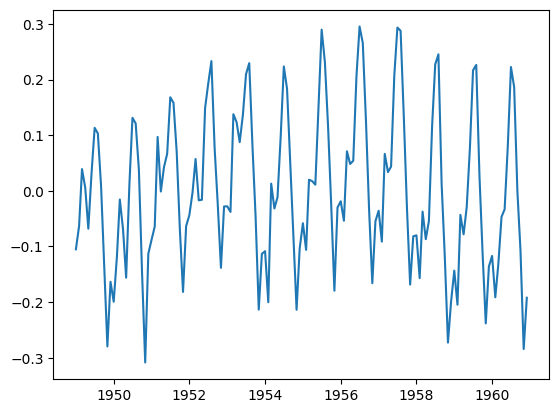

In [ ]:
df["Detrended"] = df["logPassengers"] - df["logTrend"]
plt.plot(df["Detrended"])
plt.show()

In [191]:
df["Month"] = df.index.month
month_means = df.groupby("Month")["Detrended"].mean()
df["Seasonality"] = df["Month"].map(month_means)
df

,Passengers,logPassengers,t,logTrend,Detrended,Month,Seasonality
Date,,,,,,,
1949-01-01,112,4.718499,0,4.823717,-0.105218,1,-0.085520
1949-02-01,118,4.770685,1,4.833765,-0.063080,2,-0.107554
1949-03-01,132,4.882802,2,4.843813,0.038988,3,0.022694
1949-04-01,129,4.859812,3,4.853862,0.005951,4,-0.008555
1949-05-01,121,4.795791,4,4.863910,-0.068120,5,-0.010907
...,...,...,...,...,...,...,...
1960-08-01,606,6.406880,139,6.220442,0.186438,8,0.205948
1960-09-01,508,6.230481,140,6.230490,-0.000009,9,0.061334
1960-10-01,461,6.133398,141,6.240538,-0.107140,10,-0.076804


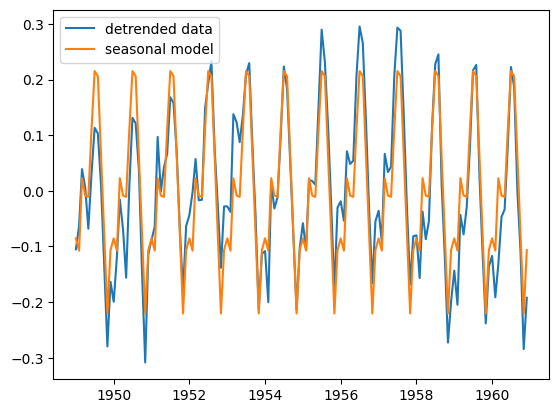

In [245]:
plt.plot(df["Detrended"], label="detrended data")
plt.plot(df["Seasonality"], label="seasonal model")
plt.legend(loc="upper left")
plt.show()

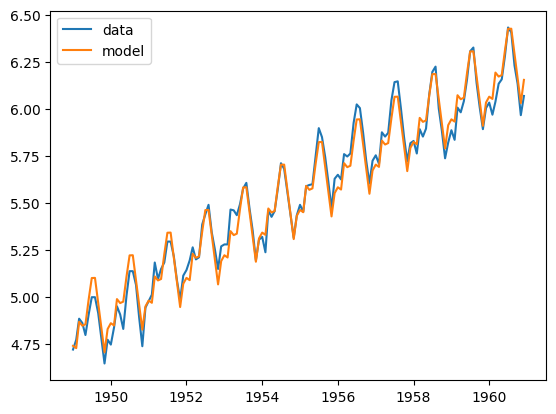

In [239]:
plt.plot(df["logPassengers"], label="data")
plt.plot(df["logTrend"] + df["Seasonality"], label="model")
plt.legend()
plt.show()

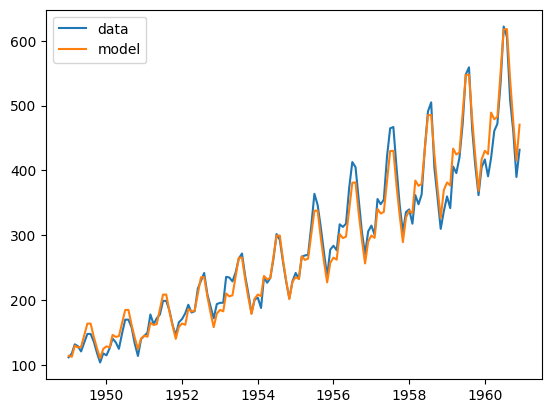

In [240]:
plt.plot(df["Passengers"], label="data")
plt.plot(np.exp(df["logTrend"] + df["Seasonality"]), label="model")
plt.legend()
plt.show()

In [228]:
X = pd.concat([df["t"], pd.get_dummies(df["Month"], prefix="Month")], axis=1)
X

,t,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,
1949-01-01,0,True,False,False,False,False,False,False,False,False,False,False,False
1949-02-01,1,False,True,False,False,False,False,False,False,False,False,False,False
1949-03-01,2,False,False,True,False,False,False,False,False,False,False,False,False
1949-04-01,3,False,False,False,True,False,False,False,False,False,False,False,False
1949-05-01,4,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08-01,139,False,False,False,False,False,False,False,True,False,False,False,False
1960-09-01,140,False,False,False,False,False,False,False,False,True,False,False,False
1960-10-01,141,False,False,False,False,False,False,False,False,False,True,False,False


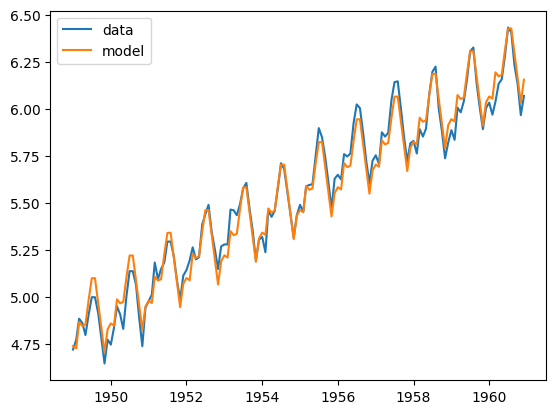

In [241]:
model = LinearRegression()
model.fit(X, df["logPassengers"])
preds = pd.Series(model.predict(X), index=X.index)
plt.plot(df.index, df["logPassengers"], label="data")
plt.plot(preds.index, preds.values, label="model")
plt.legend()
plt.show()